# Video pixel locations:

(720, 1280)


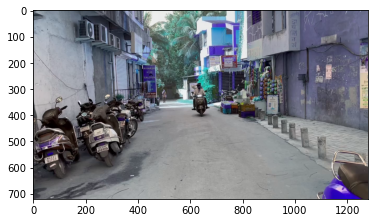

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2 as cv
cap = cv.VideoCapture(r"C:\Users\MANAS\Desktop\TY\object_tracking\Vision-Based-Navigator\Updated_CV_CP\f3.mov")
ret, frame = cap.read()
# reading the image
#testImage = img.imread(frame)
  
# displaying the image
plt.imshow(frame)
print(frame.shape[:2])

## Tracker class : 

In [1]:
import math
import numpy as np
import os
from gtts import gTTS


class Tracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect,d):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 100:
                    self.center_points[id] = (cx, cy)
                    print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break
            if same_object_detected and float(d) < 5.0 :
                    
                language = 'en'
  
                print("stop")
                output = gTTS(text="Stop", lang=language)
  

                output.save("output.mp3") 
  
                # Play the converted file 
                os.system("start output.mp3")
            

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

### Warping the image for linear distance estimation formula :

In [2]:
outputSize = [300, 600]
def changePerspective(img, draw=0):
        #pts = [leftTop,rightTop,leftBottom,rightBottom]
        #pts = [[420,750],[600,750],[0,1250],[750,1250]] #Hardcoded values for our usecase
        pts=[[230,175],[410,175],[100,352],[590,352]]
        if draw == 1:
            for point in pts:
                img = cv2.circle(img, point, 5, (0,255,0), -1)

        pts1 = np.float32(pts)
        pts2 = np.float32([[0,0],[outputSize[0],0],[0,outputSize[1]],[outputSize[0],outputSize[1]]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,outputSize)

        #colour = (0, 255, 0)
        #thickness = 3
        #img = cv2.line(img, [100,352], [230,175], colour, thickness)
        #img = cv2.line(img, [590,352], [410,175], colour, thickness)
        
        #img = cv2.line(img, [0,1250], [420,750], colour, thickness)
        #img = cv2.line(img, [750,1250], [600,750], colour, thickness)

        return img, dst

In [5]:
import cv2
"""try:
    from tracker import *
except ImportError: # will be 3.x series
    pass"""

# Create tracker object
tracker = Tracker()

cap = cv2.VideoCapture(r"C:\Users\MANAS\Desktop\TY\object_tracking\Vision-Based-Navigator\Updated_CV_CP\f3.mov")
ret, frame1 = cap.read()

roi1 = frame1[400: 720,500: 820] #3,4
#roi1 = frame1[100:,200:650] #1,2,5,6
#roi1=frame1[300:,600:1250] #7,8, 9, 10

prvs = cv2.cvtColor(roi1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(roi1)
hsv[..., 1] = 255
"""frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
params=[]"""
distance=0
while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    height, width= frame.shape[:2]

    # Extract Region of interest
    roi = frame[400: 720,500: 820] #3, 4
    #roi = frame[100:,200:650] #1, 2, 5, 6
    #roi=frame[300:,600:1250] #7,8, 9, 10

    next = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    prvs=next
    
    #distance estimation variables
    r = 7
    start_dist = 1
    objColor = (0,0,255)
    
    # 1. Object Detection
    masked  = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    ret,masked = cv2.threshold(masked,100,255,cv2.THRESH_BINARY)
    #mask = object_detector.apply(frame)
    #_, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(masked, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    perp,warp = changePerspective(masked)
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area > 400:
            #cv2.drawContours(roi, [cnt], -1, (0, 255, 0), 2)
            x, y, w, h = cv2.boundingRect(cnt)
            distance = r - (y+h)*r/warp.shape[0] + start_dist
            distance = "{:.2f}".format(distance)
        
            cv2.drawContours(masked, [cnt], -1, objColor, 3)
            masked = cv2.rectangle(masked, (x, y), (x+w, y+h), (255,255,255), 2)
            masked = cv2.putText(masked, str(distance), (x+w, y+h), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            detections.append([x, y, w, h])

    # 2. Object Tracking
    boxes_ids = tracker.update(detections,distance)
    
    for box_id in boxes_ids:
        x, y, w, h, id = box_id
        
        cv2.putText(roi, str(id), (x, y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)

    cv2.imshow("roi", roi)
    cv2.imshow("Frame", frame)
    cv2.imshow("Mask", masked)
    cv2.imshow('bgr', bgr)
    #cv2.imshow('warp', warp)
    #cv2.imshow('perspective', perp)
    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

{0: (143, 9)}
{0: (147, 11)}
{0: (141, 10)}
{0: (143, 11)}
{0: (144, 11)}
{0: (144, 12)}
{0: (149, 13)}
{0: (144, 13)}
{0: (146, 14)}
{0: (149, 15)}
{0: (149, 15)}
{0: (149, 16)}
{0: (152, 17)}
{0: (152, 18)}
{0: (150, 19)}
{0: (158, 20)}
{0: (154, 20)}
{0: (156, 20)}
{0: (151, 23)}
{0: (153, 23)}
{0: (166, 23)}
{0: (159, 24)}
{0: (152, 25)}
{0: (154, 26)}
{0: (156, 27)}
{0: (156, 28)}
{0: (157, 29)}
{0: (158, 30)}
{0: (159, 32)}
{0: (160, 31)}
{0: (160, 33)}
{0: (161, 34)}
{0: (162, 34)}
{0: (163, 35)}
{0: (163, 39)}
{0: (164, 39)}
{0: (165, 40)}
{0: (165, 42)}
{0: (166, 43)}
{0: (168, 43)}
{0: (168, 44)}
{0: (169, 46)}
{0: (170, 47)}
{0: (170, 49)}
{0: (171, 50)}
{0: (171, 51)}
{0: (172, 53)}
{0: (172, 55)}
{0: (174, 57)}
{0: (173, 58)}
{0: (173, 67)}
{0: (176, 71)}
{0: (174, 72)}
{0: (174, 75)}
{0: (173, 74)}
{0: (173, 81)}
{0: (173, 84)}
{0: (172, 83)}
{0: (172, 75)}
{0: (171, 94)}
{0: (160, 81)}
{0: (235, 70)}
{0: (156, 94)}
{0: (101, 86)}
{0: (169, 117)}
{0: (165, 114)}
{0: (153,